In [33]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
marketing_df = pd.read_csv('../3. data_after_txt_proc/bank_marketing_data_after_txt_proc.csv')
personal_df = pd.read_csv('../3. data_after_txt_proc/Bank_Personal_Loan_Modelling_after_txt_proc.csv')

# marketing_df 

In [35]:
X_m = marketing_df.drop(columns=['deposit'])  
y_m = marketing_df['deposit']

In [36]:
feature_names_m = X_m.columns.tolist()

In [37]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)


In [39]:
def objective_m(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = None
    degree = None
    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1)
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)

    model_m = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale',
            degree=degree if kernel == 'poly' else 3,
            random_state=42,
        
        ))
    ])

    score = cross_val_score(model_m, X_train_m, y_train_m, cv=5, scoring='accuracy').mean()
    return score

In [40]:
%%time
study_m = optuna.create_study(direction='maximize')
study_m.optimize(objective_m, n_trials=50)

[I 2024-12-04 15:49:14,477] A new study created in memory with name: no-name-395f4e61-1957-4c4b-b98e-9c690b16ea9a
C:\Users\mitay\AppData\Local\Temp\ipykernel_12880\3653068666.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
C:\Users\mitay\AppData\Local\Temp\ipykernel_12880\3653068666.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1)
[I 2024-12-04 15:49:23,402] Trial 0 finished with value: 0.5271586977456156 and parameters: {'C': 0.00022800792257984218, 'kernel': 'poly', 'gamma': 0.0024142994912999013, 'degree': 5}. Best is trial 0 with value: 0.5271586977456156.
C:\Use

KeyboardInterrupt: 

In [41]:
print("Best hyperparameters for marketing_df:", study_m.best_params)

Best hyperparameters for marketing_df: {'C': 0.1471813344062403, 'kernel': 'linear'}


In [42]:
best_model_m = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(
        C=study_m.best_params['C'],
        kernel=study_m.best_params['kernel'],
        gamma=study_m.best_params.get('gamma', 'scale'),
        degree=study_m.best_params.get('degree', 3),
        random_state=42
    ))
])

In [43]:
best_model_m.fit(X_train_m, y_train_m)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.1471813344062403, kernel='linear', random_state=42))])

In [21]:
# Оценка модели на тестовых данных для marketing_df
y_pred_m = best_model_m.predict(X_test_m)
y_pred_proba_m = best_model_m.predict_proba(X_test_m)[:, 1]

# Метрики
test_accuracy_m = accuracy_score(y_test_m, y_pred_m)
test_f1_m = f1_score(y_test_m, y_pred_m)
test_precision_m = precision_score(y_test_m, y_pred_m)
test_recall_m = recall_score(y_test_m, y_pred_m)
test_roc_auc_m = roc_auc_score(y_test_m, y_pred_proba_m)

# Вывод метрик
print(f"\nMetrics for marketing_df:")
print(f"Accuracy: {test_accuracy_m:.4f}")
print(f"F1 Score: {test_f1_m:.4f}")
print(f"Precision: {test_precision_m:.4f}")
print(f"Recall: {test_recall_m:.4f}")
print(f"ROC-AUC: {test_roc_auc_m:.4f}")

Test accuracy for marketing_df: 0.8083


Feature importance (via permutation) for marketing_df:
duration: 0.1792
housing: 0.0246
poutcome_success: 0.0181
age: 0.0099
contact_unknown: 0.0090
contact_cellular: 0.0072
month: 0.0071
job_student: 0.0064
loan: 0.0061
poutcome_unknown: 0.0046
pdays: 0.0039
campaign: 0.0035
marital_single: 0.0030
balance: 0.0028
job_retired: 0.0028
day: 0.0026
previous: 0.0023
job_blue-collar: 0.0014
job_admin.: 0.0012
job_services: 0.0011
job_housemaid: 0.0011
job_unemployed: 0.0011
job_entrepreneur: 0.0008
education_primary: 0.0008
marital_married: 0.0007
poutcome_other: 0.0007
education_tertiary: 0.0003
job_unknown: 0.0001
job_management: -0.0005
contact_telephone: -0.0005
job_technician: -0.0009
default: -0.0009
education_secondary: -0.0011
marital_divorced: -0.0012
job_self-employed: -0.0013
education_unknown: -0.0015
poutcome_failure: -0.0022


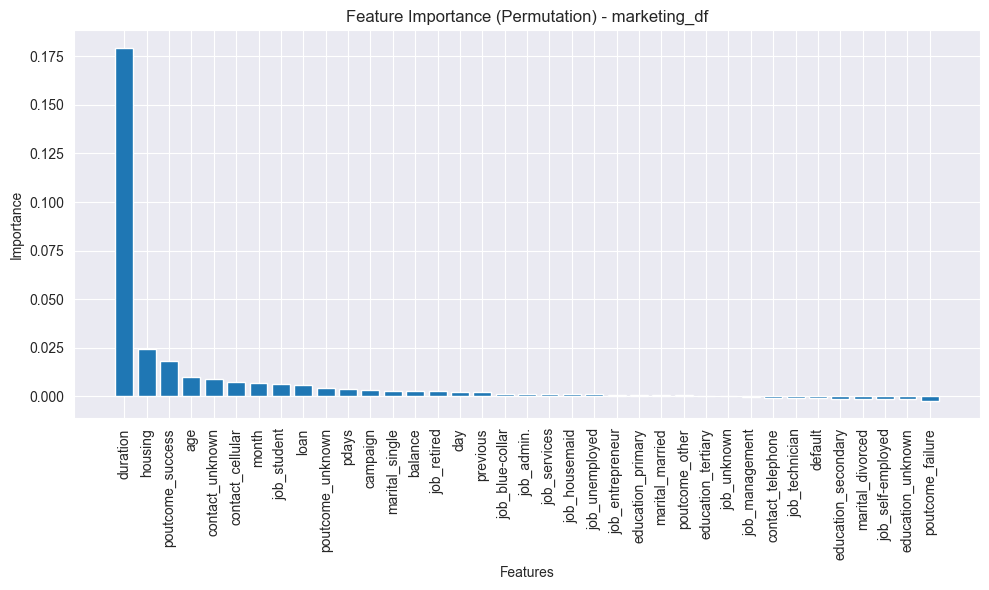

In [20]:
clf_m = best_model_m.named_steps['clf']
if study_m.best_params['kernel'] == 'linear':
    # Важность признаков через коэффициенты для линейного ядра
    feature_importances_m = np.abs(clf_m.coef_[0])
    feature_indices_m = np.argsort(feature_importances_m)[::-1]

    print("Feature importance (sorted) for marketing_df:")
    for idx in feature_indices_m:
        print(f"{feature_names_m[idx]}: {feature_importances_m[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_m)), feature_importances_m[feature_indices_m])
    plt.xticks(range(len(feature_importances_m)), [feature_names_m[i] for i in feature_indices_m], rotation=90)
    plt.title("Feature Importance (Linear Kernel) - marketing_df")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    # Важность признаков через permutation_importance для других ядер
    result_m = permutation_importance(best_model_m, X_test_m, y_test_m, n_repeats=10, random_state=42)
    importances_m = result_m.importances_mean
    feature_indices_m = np.argsort(importances_m)[::-1]

    print("Feature importance (via permutation) for marketing_df:")
    for idx in feature_indices_m:
        print(f"{feature_names_m[idx]}: {importances_m[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances_m)), importances_m[feature_indices_m])
    plt.xticks(range(len(importances_m)), [feature_names_m[i] for i in feature_indices_m], rotation=90)
    plt.title("Feature Importance (Permutation) - marketing_df")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

# Personal_df

In [24]:
X_p = personal_df.drop(columns=['Personal Loan']) 
y_p = personal_df['Personal Loan']  

In [25]:
feature_names_p = X_p.columns.tolist()

In [26]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

In [27]:
def objective_p(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = None
    degree = None
    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1)
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)

    model_p = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(
            C=C,
            kernel=kernel,
            gamma=gamma if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale',
            degree=degree if kernel == 'poly' else 3,
            random_state=42
        ))
    ])

    score = cross_val_score(model_p, X_train_p, y_train_p, cv=5, scoring='accuracy').mean()
    return score


In [28]:
study_p = optuna.create_study(direction='maximize')
study_p.optimize(objective_p, n_trials=50)

[I 2024-12-02 17:37:12,353] A new study created in memory with name: no-name-03c97a51-0914-4cfb-a859-ca8caa71bea3
C:\Users\mitay\AppData\Local\Temp\ipykernel_12880\3788802882.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)
C:\Users\mitay\AppData\Local\Temp\ipykernel_12880\3788802882.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1)
[I 2024-12-02 17:37:12,747] Trial 0 finished with value: 0.90625 and parameters: {'C': 0.09938754968144707, 'kernel': 'sigmoid', 'gamma': 9.057095459583297e-05}. Best is trial 0 with value: 0.90625.
C:\Users\mitay\AppData\Local\Temp\ipykern

In [29]:
print("Best hyperparameters for personal_df:", study_p.best_params)

Best hyperparameters for personal_df: {'C': 6.739387603788961, 'kernel': 'rbf', 'gamma': 0.05594186243987836}


In [30]:
best_model_p = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(
        C=study_p.best_params['C'],
        kernel=study_p.best_params['kernel'],
        gamma=study_p.best_params.get('gamma', 'scale'),
        degree=study_p.best_params.get('degree', 3),
        random_state=42
    ))
])
best_model_p.fit(X_train_p, y_train_p)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=6.739387603788961, gamma=0.05594186243987836,
                     random_state=42))])

In [31]:
test_score_p = best_model_p.score(X_test_p, y_test_p)
print(f"Test accuracy for personal_df: {test_score_p:.4f}")

Test accuracy for personal_df: 0.9840


Feature importance (via permutation) for personal_df:
Income: 0.1485
Education: 0.0671
Family: 0.0404
CCAvg: 0.0195
CD Account: 0.0129
Age: 0.0110
Experience: 0.0104
Online: 0.0036
CreditCard: 0.0017
Securities Account: 0.0010
Mortgage: 0.0009
ZIP Code: 0.0001


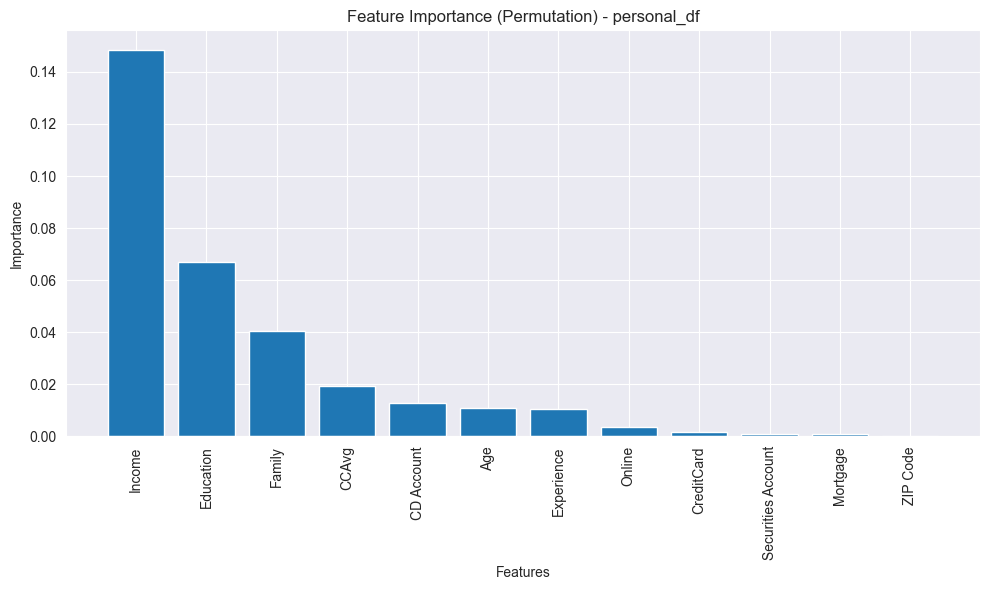

In [32]:
clf_p = best_model_p.named_steps['clf']
if study_p.best_params['kernel'] == 'linear':
    # Важность признаков через коэффициенты для линейного ядра
    feature_importances_p = np.abs(clf_p.coef_[0])
    feature_indices_p = np.argsort(feature_importances_p)[::-1]

    print("Feature importance (sorted) for personal_df:")
    for idx in feature_indices_p:
        print(f"{feature_names_p[idx]}: {feature_importances_p[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances_p)), feature_importances_p[feature_indices_p])
    plt.xticks(range(len(feature_importances_p)), [feature_names_p[i] for i in feature_indices_p], rotation=90)
    plt.title("Feature Importance (Linear Kernel) - personal_df")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute coefficient value)")
    plt.tight_layout()
    plt.show()
else:
    # Важность признаков через permutation_importance для других ядер
    result_p = permutation_importance(best_model_p, X_test_p, y_test_p, n_repeats=10, random_state=42)
    importances_p = result_p.importances_mean
    feature_indices_p = np.argsort(importances_p)[::-1]

    print("Feature importance (via permutation) for personal_df:")
    for idx in feature_indices_p:
        print(f"{feature_names_p[idx]}: {importances_p[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances_p)), importances_p[feature_indices_p])
    plt.xticks(range(len(importances_p)), [feature_names_p[i] for i in feature_indices_p], rotation=90)
    plt.title("Feature Importance (Permutation) - personal_df")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()